In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

import emg3d
import pygimli as pg

# Requires currently branch inversion:
# pip install git+https://github.com/emsig/emg3d@inversion
from emg3d.inversion.pygimli import Inversion

In [2]:
start_data = emg3d.load('ModSynth_CSEM_start.h5') 
true_data = emg3d.load('ModSynth_CSEM_true.h5')
survey_data = emg3d.load('Surv_3x9_rot10_27src_W123_TxW_withofflineData_CF_24-03-06.h5')

Data loaded from «/palmyra/data/mecarrizomasca/dev-pygimli-emg3d/ModSynth_CSEM_start.h5»
[emg3d v1.8.3.dev10+g6aee03e (format 1.0) on 2024-03-08T13:57:30.369560].
Data loaded from «/palmyra/data/mecarrizomasca/dev-pygimli-emg3d/ModSynth_CSEM_true.h5»
[emg3d v1.8.3.dev10+g6aee03e (format 1.0) on 2024-03-08T13:57:46.372037].
Data loaded from «/palmyra/data/mecarrizomasca/dev-pygimli-emg3d/Surv_3x9_rot10_27src_W123_TxW_withofflineData_CF_24-03-06.h5»
[emg3d v1.8.1 (format 1.0) on 2024-03-06T11:00:10.505448].


In [37]:
start_model

Model: log_10(conductivity); isotropic; 213 x 151 x 49 (1,575,987)

In [3]:
start_model= start_data['model']
true_model = true_data['model']
survey = survey_data['survey']

survey = survey.select(sources = ['RxW11', 'RxW31', 'RxW51', 'RxW73', 'RxW93'], 
                       frequencies='f-1')

#survey = survey.select(sources = 'RxW51', 
#                       frequencies='f-1')

rec_coords = survey.receiver_coordinates()
src_coords = survey.source_coordinates()

In [4]:
start_grid = start_model.grid
true_grid = true_model.grid

In [5]:
start_grid

TensorMesh: 1,575,987 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    213    128,920.00    163,000.00    160.00    160.00    1.00
   y    151  3,023,920.00  3,048,080.00    160.00    160.00    1.00
   z     49     -2,000.00        300.00     20.00    200.00   10.00

In [6]:
true_grid

TensorMesh: 1,575,987 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    213    128,920.00    163,000.00    160.00    160.00    1.00
   y    151  3,023,920.00  3,048,080.00    160.00    160.00    1.00
   z     49     -2,000.00        300.00     20.00    200.00   10.00

In [7]:
# The model is resistivity. Change it to conductivity
# TODO: make this internally happen, so that pyGIMLi
# always gets a conductivity model!
start_LgCon_model = emg3d.Model(start_grid, start_model.property_x, mapping='LgConductivity')
true_LgCon_model = emg3d.Model(true_grid, true_model.property_x, mapping='LgConductivity')

# Convert to conductivity
StartModCond = 10**start_model.property_x
TrueModCond = 10**true_model.property_x

start_con_model = emg3d.Model(start_grid, StartModCond, mapping='Conductivity')
true_con_model = emg3d.Model(true_grid, TrueModCond, mapping='Conductivity')

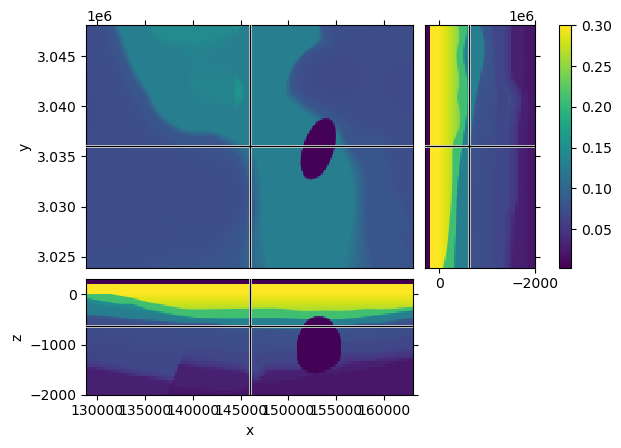

In [8]:
start_grid.plot_3d_slicer(start_con_model.property_x, clim=[3e-3,3e-1])


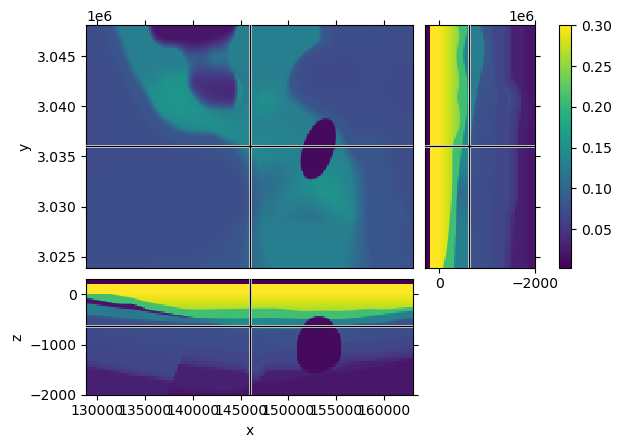

In [9]:
true_grid.plot_3d_slicer(true_con_model.property_x, clim = [3e-3, 3e-1])

In [35]:
gopts = {
    'properties': [0.3, 10, 1., 0.3],
    'min_width_limits': (200, 200, 20),
    'stretching': (None, None, [1.5, 1.5]),
    'domain': (
        [rec_coords[0].min()-100, rec_coords[0].max()+100],
        [rec_coords[1].min()-100, rec_coords[1].max()+100],
        [-2000,0]
    ),
    'center_on_edge': False,
}

In [36]:
# Create an emg3d Simulation instance
sim = emg3d.simulations.Simulation(
    survey=survey,
    model=start_con_model,
    gridding='both', #'same',  # I would like to make that more flexible in the future
    gridding_opts= gopts, #{'vector': 'xyz'},
    max_workers=20,    # Adjust as needed
    receiver_interpolation='linear',  # Currently necessary for the gradient
    ### Tolerance: TODO: different ones for forward and adjoints
    solver_opts={'tol': 1e-3},                # Just for dev-purpose
    tqdm_opts=False,  # Switch off verbose progress bars
    #verb=3,
)
sim

:: Simulation ::

- Survey «Surv_ModSynth_3x9_rot10_27src-TxW»: 5 sources; 483 receivers; 1 frequencies
- Model: conductivity; isotropic; 213 x 151 x 49 (1,575,987)
- Gridding: Frequency- and source-dependent grids; 192 x 80 x 32 (491,520)

In [12]:
#sim.compute(observed=True)
#del survey.data['synthetic']  # Observed (with noise) remains stored

In [13]:
#survey

In [14]:
#
#del survey.data['synthetic']  # Observed (with noise) remains stored

In [15]:
#rec_coords = sim.survey.receiver_coordinates()
#src_coords = sim.survey.source_coordinates()

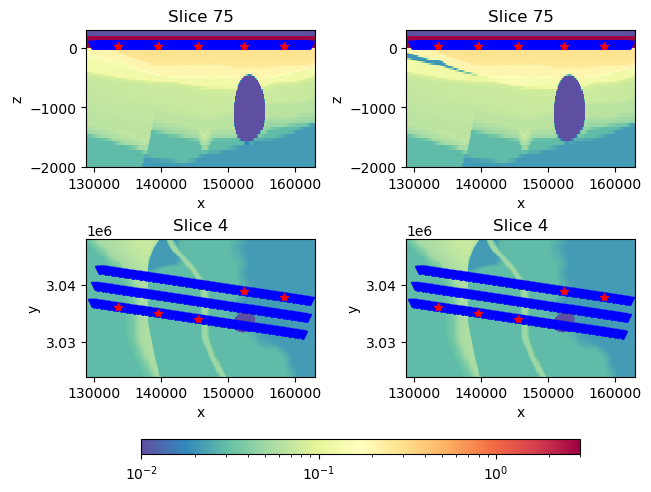

In [16]:
fig, ax = plt.subplots(2,2, constrained_layout=True)
opts = {'v_type': 'CC', 'normal': 'Y'}
popts1 = {'cmap':'Spectral_r','norm':LogNorm(vmin=1e-2, vmax=3)}

cb, = start_grid.plot_slice(start_con_model.property_x.ravel('F'), ax=ax[0,0], pcolor_opts=popts1, **opts)
ax[0,0].plot(rec_coords[0], rec_coords[2], 'bv')
ax[0,0].plot(src_coords[0], src_coords[2], 'r*')

true_grid.plot_slice(true_con_model.property_x.ravel('F'), ax = ax[0,1], pcolor_opts=popts1, **opts)
ax[0,1].plot(rec_coords[0], rec_coords[2], 'bv')
ax[0,1].plot(src_coords[0], src_coords[2], 'r*')

opts['normal'] = 'Z'
opts['ind'] = 4

start_grid.plot_slice(start_con_model.property_x.ravel('F'), ax=ax[1,0], pcolor_opts=popts1, **opts)
ax[1,0].plot(rec_coords[0], rec_coords[1], 'bv')
ax[1,0].plot(src_coords[0], src_coords[1], 'r*')

true_grid.plot_slice(true_con_model.property_x.ravel('F'), ax = ax[1,1], pcolor_opts=popts1, **opts)
ax[1,1].plot(rec_coords[0], rec_coords[1], 'bv')
ax[1,1].plot(src_coords[0], src_coords[1], 'r*')

plt.colorbar(cb, ax=ax, orientation='horizontal', fraction=.1, shrink=.8, aspect=30)

# Inversion

In [25]:
INV = Inversion(fop=sim, verbose=True) #, debug=True)
INV.inv.setCGLSTolerance(10)  # is _absolute_, not _relative_
INV.inv.setMaxCGLSIter(30)

#INV.dataTrans = pg.trans.TransSymLog(sim.survey.noise_floor)

# Create region markers
# Set marker -> air is 2, water is 1, subsurface is 0 ?
#air
#INV.inv_mesh.setCellMarkers(pg.z(INV.inv_mesh.cellCenters()) >= 200)
# water
#INV.inv_mesh.setCellMarkers((pg.z(INV.inv_mesh.cellCenters()) > 0) & (pg.z(INV.inv_mesh.cellCenters()) < 200))
#pg.show(INV.inv_mesh)

for c in INV.inv_mesh.cells():
    if c.center()[2] >= 200:
        c.setMarker(2)
    elif (c.center()[2] > 0) & (c.center()[2] < 200):
        c.setMarker(1)

# , zWeight=0.2
# , correlationLengths=[1000, 1000, 300])

INV.setRegularization(0, limits = (3e-3, 3e-1), zWeight=0.2) #, startModel=3e-2)
INV.setRegularization(1, limits = (3.43, 3.45), startModel=3.44) # , single=True)
INV.setRegularization(2, limits = (9e-9, 2e-8), startModel=1e-8)

# 0 only damping (minimum length; only useful with good starting model and isReference=True in INV)
# 1 1st deriv - smoothing
# 2 2nd deriv
# 10, 20 - mixed form

# außerdem kann man der Inversion inv.setPostStep(fct) und inv.setPreStep(fct) mitgeben,
# die als def fct(iter, inv): die Iterationszahl und die Inversionsinstanz bekommt,
# damit kann man machen was man will 

In [26]:
errmodel = INV.run(
    maxIter=1, # just to test
    lam=10,  # btw 1-100
    verbose=True,
    startModel=start_con_model.property_x.ravel('F'),
    isReference=True,
)

21/03/24 - 14:32:07 - pyGIMLi - INFO - pyGIMLi(emg3d) START
21/03/24 - 14:33:15 - pyGIMLi - INFO - Starting inversion.
21/03/24 - 14:33:15 - pyGIMLi - INFO - Setting starting model as reference!


min/max(dweight) = 10000/9.94881e+12
fop: <emg3d.inversion.pygimli.Kernel object at 0x7fcae144d170>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7fcabc89a880>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7fcabc89a8f0>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x7fcabc89a960>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x7fcabc89a9d0>
min/max (data): -1.0e-10/3.5e-10
min/max (error): 1.04%/1.0e+10%
min/max (start model): 1.0e-08/3.45
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 10000/9.94881e+12
Building constraints matrix
constraint matrix of size(nBounds x nModel) 4613636 x 1575987


21/03/24 - 14:33:53 - pyGIMLi - INFO - 0: χ² =  450.09; λ = 10.0; #CGLS  0 ( 1 solves); ϕ = 1434877.48 + 0.00 = 1434877.48


Calculating Jacobian matrix (forced=1)...... 1.1411e-05 s
inv.iter 0 ... chi² =  481.48
min data = -1.03792e-10 max data = 3.51946e-10 (3188)
min error = 0.0104297 max error = 1e+08 (3188)
min response = -1.19766e-10 max response = 5.20693e-10 (3188)
min reference model = 1e-08 max reference model = 3.44826 (1575987)
0: rms/rrms(data, response) = 1.59507e-11/164084%
0: chi^2(data, response, error, log) = 450.087
0: Phi = 1.43488e+06 + 0 * 10 = 1.43488e+06
--------------------------------------------------------------------------------
inv.iter 1 ... solve CGLSCDWWtrans with lambda = 10
Performing line search with tau = 1
1: Model: min = 2e-08; max = 3.44994
1: Response: min = -1.18393e-10; max = 5.02261e-10
1: rms/rrms(data, Response) = 1.50321e-11/68837.6%
1: chi^2(data, Response, error, log) = 171.105
1: Phi = 545483+20031.1*10=745794


21/03/24 - 15:24:01 - pyGIMLi - INFO - 2: χ² =  171.11; λ = 10.0; #CGLS 30 (64 solves); ϕ = 545483.14 + 20031.07 = 745793.87; Δϕ = 48.02%
21/03/24 - 15:24:01 - pyGIMLi - INFO - pyGIMLi(emg3d) END :: 0:51:55


chi² =  171.11 (dPhi = 50.13%) lam: 10.0


In [27]:
# Add inversion result to data;
# I should wrap these few lines into a function, as they are used above as well
idata = np.ones(sim.survey.shape, dtype=sim.data.observed.dtype)*np.nan
x = np.asarray(INV.response)
idata[sim.survey.isfinite] = x[:x.size//2] + 1j*x[x.size//2:]
sim.survey.data['inv'] = sim.survey.data.observed.copy(data=idata)

# Compute the 2-layer model as comparison
sim.clean('computed')
sim.model = start_con_model
sim.compute()  # <- puts it into 'synthetic'

In [28]:
# Store final model as model to be saved with the simulation
sim.model = emg3d.Model(start_grid, np.array(INV.model), mapping='Conductivity')
#sim.to_file('Simulation-CSEM-StartModel.h5')

## Check results of inversion

In [29]:
#sim = emg3d.load('Simulation-CSEM-StartModel_Ref_5s.h5')
#sim = sim['simulation']

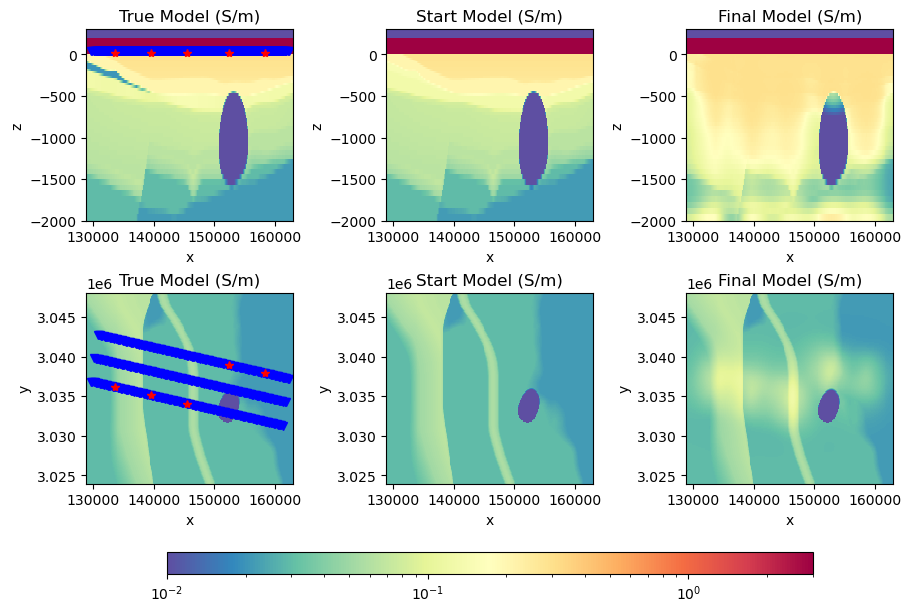

In [30]:
popts1 = {'cmap':'Spectral_r','norm':LogNorm(vmin=1e-2, vmax=3)}
popts2 = {'edgecolors': 'grey', 'linewidth': 0.5, 'cmap':'Spectral_r','norm':LogNorm(vmin=1e-2, vmax=3)}
opts = {'v_type': 'CC', 'normal': 'Y'}

#rec_coords = sim.survey.receiver_coordinates()
#src_coords = sim.survey.source_coordinates()

fig, axs = plt.subplots(2, 3, figsize=(9, 6), constrained_layout=True)#, sharex=True, sharey='col')
(ax1, ax2, ax3), (ax4, ax5, ax6) = axs

# True model
out1, = true_con_model.grid.plot_slice(true_con_model.property_x.ravel('F'), ax=ax1, pcolor_opts=popts1, **opts,
                                      range_y=[-2000,300])
ax1.set_title(f"True Model (S/m)")
ax1.plot(rec_coords[0], rec_coords[2], 'bv')
ax1.plot(src_coords[0], src_coords[2], 'r*')
ax1.set_ylim([-2000,300])

# Start model
out2, = start_con_model.grid.plot_slice(start_con_model.property_x.ravel('F'), ax=ax2, pcolor_opts=popts1, **opts,
                                       range_y=[-2000,300])
ax2.set_title(f"Start Model (S/m)")
ax2.set_ylim([-2000,300])

# Final inversion model
out3, = start_con_model.grid.plot_slice(sim.model.property_x.ravel('F'), ax=ax3, pcolor_opts=popts1, **opts,
                                       range_y=[-2000,300])
ax3.set_title(f"Final Model (S/m)")
ax3.set_ylim([-2000,300])

opts['normal'] = 'Z'
opts['ind'] = 5

# True model
out4, = true_con_model.grid.plot_slice(true_con_model.property_x.ravel('F'), ax=ax4, pcolor_opts=popts1, **opts)
ax4.set_title(f"True Model (S/m)")
ax4.plot(rec_coords[0], rec_coords[1], 'bv')
ax4.plot(src_coords[0], src_coords[1], 'r*')

# Start model
out5, = start_con_model.grid.plot_slice(start_con_model.property_x.ravel('F'), ax=ax5, pcolor_opts=popts1, **opts)
ax5.set_title(f"Start Model (S/m)")

# Final inversion model
out6, = start_con_model.grid.plot_slice(sim.model.property_x.ravel('F'), ax=ax6, pcolor_opts=popts1, **opts)
ax6.set_title(f"Final Model (S/m)")

#for ax in axs.ravel():
#    ax.axis('equal')

plt.colorbar(out1, ax=axs, orientation='horizontal', fraction=.1, shrink=.8, aspect=30)

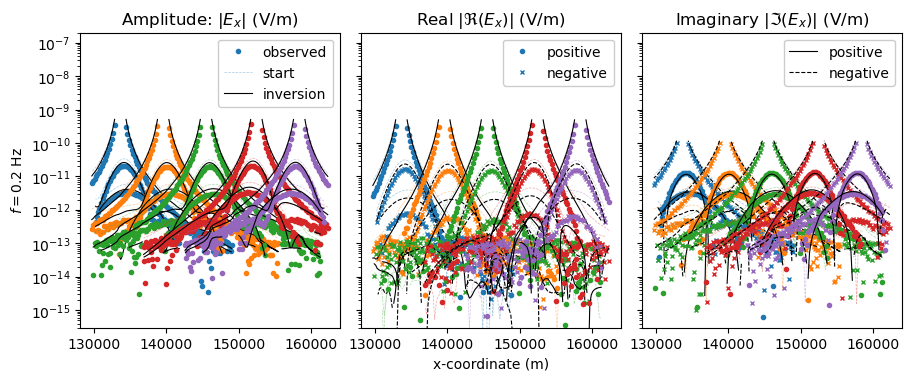

In [24]:
def pos(data):
    """Return positive data; set negative data to NaN."""
    return np.where(data > 0, data, np.nan)
    

height = sim.survey.shape[2]*1.7+2
fig, axs = plt.subplots(sim.survey.shape[2], 3, figsize=(9, height), constrained_layout=True, sharex=True, sharey=True)
axs = np.atleast_2d(axs)  # So it works if only 1 freq

# Data
obs = sim.data.observed
syn = sim.data.inv
syn.data[~np.isfinite(obs.data)] = np.nan+1j*np.nan
two = sim.data.synthetic
two.data[~np.isfinite(obs.data)] = np.nan+1j*np.nan

rec_coords = sim.survey.receiver_coordinates()

for ii, freq in enumerate(sim.survey.frequencies.keys()):
    for i, src in enumerate(sim.survey.sources.keys()):
        #if i in [1, 3, 5]:
        #    continue
        
        # Observed data
        axs[ii, 0].plot(rec_coords[0], abs(obs.loc[src, :, freq].data), f"C{i}.",
                        label='observed' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], pos(obs.loc[src, :, freq].data.real), f"C{i}.",
                        label='positive' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], pos(-obs.loc[src, :, freq].data.real), f"C{i}x", ms=3,
                        label='negative' if i == 0 else '')
        axs[ii, 2].plot(rec_coords[0], pos(obs.loc[src, :, freq].data.imag), f"C{i}.")
        axs[ii, 2].plot(rec_coords[0], pos(-obs.loc[src, :, freq].data.imag), f"C{i}x", ms=3)
        
        # Start model
        axs[ii, 0].plot(rec_coords[0], abs(two.loc[src, :, freq].data), f"C{i}--", alpha=.4, lw=0.5,
                        label='start' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], abs(two.loc[src, :, freq].data.real), f"C{i}--", alpha=.4, lw=0.5)
        axs[ii, 2].plot(rec_coords[0], abs(two.loc[src, :, freq].data.imag), f"C{i}--", alpha=.4, lw=0.5)
        
        # Inverted data
        axs[ii, 0].plot(rec_coords[0], abs(syn.loc[src, :, freq].data), f"k-", lw=0.8,
                        label='inversion' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], pos(syn.loc[src, :, freq].data.real), f"k-", lw=0.8)
        axs[ii, 1].plot(rec_coords[0], pos(-syn.loc[src, :, freq].data.real), f"k--", lw=0.8)
        axs[ii, 2].plot(rec_coords[0], pos(syn.loc[src, :, freq].data.imag), f"k-", lw=0.8,
                        label='positive' if i == 0 else '')
        axs[ii, 2].plot(rec_coords[0], pos(-syn.loc[src, :, freq].data.imag), f"k--", lw=0.8,
                        label='negative' if i == 0 else '')
        

    axs[ii, 0].set_ylabel(f'$f={sim.survey.frequencies[freq]}$ Hz')     

        
axs[0, 0].set_yscale('log')
axs[0, 0].set_ylim([3e-16, 2e-7])

axs[0, 0].set_title('Amplitude: $|E_x|$ (V/m)')
axs[0, 1].set_title('Real $|\Re(E_x)|$ (V/m)')
axs[0, 2].set_title('Imaginary $|\Im(E_x)|$ (V/m)')

axs[0, 0].legend(framealpha=1)
axs[0, 1].legend(framealpha=1)
axs[0, 2].legend(framealpha=1)

axs[-1, 1].set_xlabel('x-coordinate (m)')
#plt.savefig('ResponseFit-7x7-Test_all.png', dpi=300)
plt.show()